In [29]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import faiss

In [30]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('data/u.user', sep='|', names=user_columns)
users_df.head(2)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [31]:
genre_df = pd.read_csv("data/u.genre", sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
print(genre_columns)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [32]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('data/u.item', sep='|', names=movie_columns+genre_columns,
                     encoding='latin-1')
movies_df = movies_df[["movie_id", "title", "release_date"] + genre_columns]
movies_df.head(2)

,movie_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('data/u.data', sep='\t', names=ratings_columns)
# ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 )
ratings_df

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [34]:
# Chia 80/20 theo thời gian của từng user_id
def split_train_test_by_user(df, user_col='user_id', time_col='unix_timestamp', train_ratio=0.8):
    train_list = []
    test_list = []

    # Lặp qua từng user
    for user_id, user_data in df.groupby(user_col):
        # Sắp xếp dữ liệu của user theo thời gian
        user_data = user_data.sort_values(by=time_col)

        # Xác định số lượng dòng thuộc train (80%) và test (20%)
        train_size = int(len(user_data) * train_ratio)

        # Chia dữ liệu
        train_list.append(user_data.iloc[:train_size])  # 80% đầu tiên
        test_list.append(user_data.iloc[train_size:])  # 20% cuối cùng

    # Kết hợp lại thành DataFrame
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    return train_df, test_df

# Gọi hàm chia dữ liệu
train_df, test_df = split_train_test_by_user(ratings_df, user_col='user_id', time_col='unix_timestamp')

train_df.drop( "unix_timestamp", inplace = True, axis = 1 )
test_df.drop( "unix_timestamp", inplace = True, axis = 1 )
test_df

,user_id,movie_id,rating
74847,1,116,3
10508,1,208,5
8976,1,12,5
5233,1,125,3
83307,1,3,4
...,...,...,...
81005,943,450,1
95003,943,230,1
95291,943,228,3
92536,943,227,1


In [35]:
rating_movies_df = train_df.merge(movies_df, how="outer")
print(rating_movies_df.shape)
rating_movies_df.head(2)

(79690, 24)


,user_id,movie_id,rating,title,release_date,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1,5.0,Toy Story (1995),01-Jan-1995,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1,4.0,Toy Story (1995),01-Jan-1995,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),5
1,1-900 (1994),4
2,101 Dalmatians (1996),75
3,12 Angry Men (1957),109
4,187 (1997),28


In [37]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")
rating_movies_df.head()

,user_id,movie_id,rating,title,release_date,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,total_rating_count
0,299.0,1300,2.0,'Til There Was You (1997),30-May-1997,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
1,342.0,1300,1.0,'Til There Was You (1997),30-May-1997,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
2,416.0,1300,3.0,'Til There Was You (1997),30-May-1997,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
3,532.0,1300,3.0,'Til There Was You (1997),30-May-1997,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
4,782.0,1300,2.0,'Til There Was You (1997),30-May-1997,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5


In [38]:
rating_movies_df.total_rating_count.describe()

count    79690.000000
mean       150.861112
std        112.657745
min          0.000000
25%         61.000000
50%        128.000000
75%        212.000000
max        514.000000
Name: total_rating_count, dtype: float64

In [39]:
ratings_threshold = 100
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.head()

(48557, 25)


,user_id,movie_id,rating,title,release_date,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,total_rating_count
84,6.0,178,4.0,12 Angry Men (1957),01-Jan-1957,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,109
85,7.0,178,4.0,12 Angry Men (1957),01-Jan-1957,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,109
86,10.0,178,5.0,12 Angry Men (1957),01-Jan-1957,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,109
87,13.0,178,4.0,12 Angry Men (1957),01-Jan-1957,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,109
88,16.0,178,5.0,12 Angry Men (1957),01-Jan-1957,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,109


In [40]:
user_features_df = rating_popular_movies_df.pivot_table(index="user_id", columns="title", values="rating").fillna(0.0)

In [41]:
user_features_matrix = csr_matrix(user_features_df)

In [42]:
user_features_df

title,12 Angry Men (1957),2001: A Space Odyssey (1968),"Abyss, The (1989)","African Queen, The (1951)",Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),"American President, The (1995)",...,Unforgiven (1992),"Usual Suspects, The (1995)",Vertigo (1958),Volcano (1997),Wag the Dog (1997),When Harry Met Sally... (1989),While You Were Sleeping (1995),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)",Young Frankenstein (1974)
user_id,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,4.0,3.0,0.0,0.0,4.0,5.0,5.0,5.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940.0,0.0,0.0,0.0,0.0,5.0,5.0,3.0,0.0,4.0,4.0,...,0.0,0.0,0.0,4.0,3.0,4.0,0.0,3.0,0.0,0.0
941.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Bước 1: Lọc các phim phổ biến dựa vào ngưỡng đánh giá
ratings_threshold = 100
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]

# Bước 2: Tạo bảng User-Item Matrix với movie_id làm cột
user_features_df = rating_popular_movies_df.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating"
).fillna(0.0)  # Điền giá trị 0 cho các ô trống

# Bước 3: Chuyển ma trận thành CSR Matrix (nếu cần)
user_features_matrix = csr_matrix(user_features_df.values)

# Bước 4: Kiểm tra kết quả
print("Ma trận User-Movie:")
print(user_features_df)

# Kiểm tra các cột movie_id
print("\nCác movie_id trong cột:")
print(user_features_df.columns)


Ma trận User-Movie:
movie_id  1     4     7     8     9     11    12    13    14    15    ...  \
user_id                                                               ...   
1.0        5.0   3.0   4.0   1.0   0.0   2.0   0.0   5.0   5.0   5.0  ...   
2.0        4.0   0.0   0.0   0.0   0.0   0.0   0.0   4.0   4.0   0.0  ...   
3.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4.0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5.0        4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
939.0      0.0   0.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0   5.0  ...   
940.0      0.0   0.0   4.0   5.0   3.0   0.0   0.0   0.0   3.0   0.0  ...   
941.0      0.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
942.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
943.0      0.0   0.0   0.0   0.0   3.0   4.0   5.0   0.0

In [44]:
# Chuyển đổi user_features_df thành numpy array
prediction_matrix = user_features_df.copy()  # Giữ lại ma trận gốc
prediction_array = prediction_matrix.values.astype('float32')  # Chuyển thành numpy array dạng float32

In [45]:
def recommend_with_faiss(user_id, prediction_array, prediction_matrix, ratings_df, k=10, rec_top_n=10, min_rating=3.5):
    """
    Gợi ý phim dựa trên FAISS và dữ liệu đánh giá.

    Parameters:
    - user_id: int, ID của người dùng hiện tại.
    - prediction_array: numpy array, ma trận rating (user x movie).
    - prediction_matrix: DataFrame, bảng ma trận User-Item với user_id là index.
    - ratings_df: DataFrame, bảng dữ liệu đánh giá (rating_popular_movies_df).
    - k: int, số lượng người dùng tương đồng cần tìm.
    - rec_top_n: int, số lượng phim gợi ý tối đa.
    - min_rating: float, mức rating tối thiểu để xem xét phim.

    Returns:
    - List các phim gợi ý dưới dạng [[movie_id, final_score], ...].
    """
    # Tạo FAISS Index và tìm k người dùng tương tự
    user_vector = prediction_array[prediction_matrix.index.get_loc(user_id)].reshape(1, -1)
    dimension = prediction_array.shape[1]
    faiss_index = faiss.IndexFlatL2(dimension)  # FAISS sử dụng Euclidean Distance
    faiss_index.add(prediction_array)
    distances, indices = faiss_index.search(user_vector, k + 1)

    # Loại user hiện tại và lấy danh sách user_id tương tự
    similar_user_ids = [prediction_matrix.index[i] for i in indices.flatten()[1:]]
    similarities = 1 / (1 + distances.flatten()[1:])  # Độ tương đồng: 1 / (1 + distance)

    # Lấy đánh giá từ những người dùng tương tự
    sel_ratings = ratings_df.loc[
        ratings_df.user_id.isin(similar_user_ids) & (ratings_df.rating >= min_rating)
    ]

    # Loại bỏ phim đã xem bởi user hiện tại
    seen_movies = ratings_df.loc[ratings_df.user_id == user_id, "movie_id"].unique()
    sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(seen_movies)]

    # Tính điểm trung bình có trọng số
    movie_scores = {}
    for movie_id in sel_ratings["movie_id"].unique():
        group = sel_ratings[sel_ratings.movie_id == movie_id]
        numerator = sum(similarities[similar_user_ids.index(row.user_id)] * row.rating for _, row in group.iterrows())
        denominator = sum(similarities[similar_user_ids.index(row.user_id)] for _, row in group.iterrows())
        movie_scores[movie_id] = numerator / denominator if denominator != 0 else 0

    # Sắp xếp phim theo điểm số
    top_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:rec_top_n]
    return [[movie_id, round(score, 4)] for movie_id, score in top_movies]


In [46]:
# Ví dụ: Gọi hàm recommend_with_faiss
user_id_to_test = 1  # User ID bạn muốn gợi ý
recommended_movies = recommend_with_faiss(
    user_id=user_id_to_test,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=5,
    rec_top_n=10,
    min_rating=3.5
)

# In kết quả
print(f"Phim gợi ý cho User ID {user_id_to_test}:")
print(recommended_movies)


Phim gợi ý cho User ID 1:
[[515, 5.0], [129, 5.0], [483, 5.0], [654, 5.0], [9, 5.0], [357, 5.0], [58, 5.0], [209, 5.0], [474, 4.6478], [100, 4.5302]]


In [47]:
import numpy as np

def calculate_hit_rate_and_ndcg(recommend_func, test_df, prediction_array, prediction_matrix, ratings_df, k=5, rec_top_n=10, min_rating=3.5):
    """
    Tính Hit Rate (HR) và NDCG cho toàn bộ người dùng trong test_df.

    Args:
        recommend_func (function): Hàm gợi ý phim.
        test_df (DataFrame): Tập dữ liệu test.
        prediction_array (np.array): Ma trận numpy chứa đặc trưng người dùng.
        prediction_matrix (DataFrame): Ma trận đặc trưng giữ chỉ số user_id.
        ratings_df (DataFrame): Bảng đánh giá phim.
        k (int): Số lượng người dùng tương tự.
        rec_top_n (int): Số lượng phim gợi ý.
        min_rating (float): Mức rating tối thiểu.

    Returns:
        hit_rate (float): Tỉ lệ HR cho toàn bộ người dùng.
        ndcg (float): Giá trị NDCG cho toàn bộ người dùng.
    """
    total_users = test_df['user_id'].nunique()
    hits = 0  # Số lần "hit" (gợi ý đúng ít nhất 1 phim)
    ndcg_sum = 0  # Tổng NDCG cho toàn bộ người dùng

    for user_id in test_df['user_id'].unique():
        # Gọi hàm gợi ý phim
        recommended_movies = recommend_func(
            user_id=user_id,
            prediction_array=prediction_array,
            prediction_matrix=prediction_matrix,
            ratings_df=ratings_df,
            k=k,
            rec_top_n=rec_top_n,
            min_rating=min_rating
        )
        recommended_movie_ids = [movie[0] for movie in recommended_movies]  # Lấy danh sách movie_id từ gợi ý

        # Lấy các phim thực tế mà người dùng đã xem trong test_df
        actual_movies = test_df.loc[test_df['user_id'] == user_id, 'movie_id'].values

        # Kiểm tra xem có phim nào trong danh sách gợi ý trùng với thực tế không
        if set(recommended_movie_ids) & set(actual_movies):
            hits += 1

        # Tính NDCG
        dcg = 0
        idcg = 0
        for i, movie_id in enumerate(recommended_movie_ids):
            if movie_id in actual_movies:
                dcg += 1 / np.log2(i + 2)  # i + 2 vì log2(1) = 0
        for i in range(min(len(actual_movies), rec_top_n)):
            idcg += 1 / np.log2(i + 2)
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_sum += ndcg

    # Tính Hit Rate và NDCG trung bình
    hit_rate = hits / total_users
    avg_ndcg = ndcg_sum / total_users
    return hit_rate, avg_ndcg

In [ ]:
# Tính HR và NDCG
hit_rate3, avg_ndcg3 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=3,
    rec_top_n=10,
    min_rating=3.0
)
hit_rate4, avg_ndcg4 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=4,
    rec_top_n=10,
    min_rating=3.0
)
hit_rate5, avg_ndcg5 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=5,
    rec_top_n=10,
    min_rating=3.0
)
hit_rate6, avg_ndcg6 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=6,
    rec_top_n=10,
    min_rating=3.0
)
hit_rate7, avg_ndcg7 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=7,
    rec_top_n=10,
    min_rating=3.0
)
hit_rate8, avg_ndcg8 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=8,
    rec_top_n=10,
    min_rating=3.0
)
hit_rate9, avg_ndcg9 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=9,
    rec_top_n=10,
    min_rating=3.0
)
hit_rate10, avg_ndcg10 = calculate_hit_rate_and_ndcg(
    recommend_func=recommend_with_faiss,
    test_df=test_df,
    prediction_array=prediction_array,
    prediction_matrix=prediction_matrix,
    ratings_df=rating_popular_movies_df,
    k=10,
    rec_top_n=10,
    min_rating=3.0
)
# In kết quả
print(f"Hit Rate (k=3): {hit_rate3:.4f}, NDCG (k=3): {avg_ndcg3:.4f}")
print(f"Hit Rate (k=4): {hit_rate4:.4f}, NDCG (k=4): {avg_ndcg4:.4f}")
print(f"Hit Rate (k=5): {hit_rate5:.4f}, NDCG (k=5): {avg_ndcg5:.4f}")
print(f"Hit Rate (k=6): {hit_rate6:.4f}, NDCG (k=6): {avg_ndcg6:.4f}")
print(f"Hit Rate (k=7): {hit_rate7:.4f}, NDCG (k=7): {avg_ndcg7:.4f}")
print(f"Hit Rate (k=8): {hit_rate8:.4f}, NDCG (k=8): {avg_ndcg8:.4f}")
print(f"Hit Rate (k=9): {hit_rate9:.4f}, NDCG (k=9): {avg_ndcg9:.4f}")
print(f"Hit Rate (k=10): {hit_rate10:.4f}, NDCG (k=10): {avg_ndcg10:.4f}")

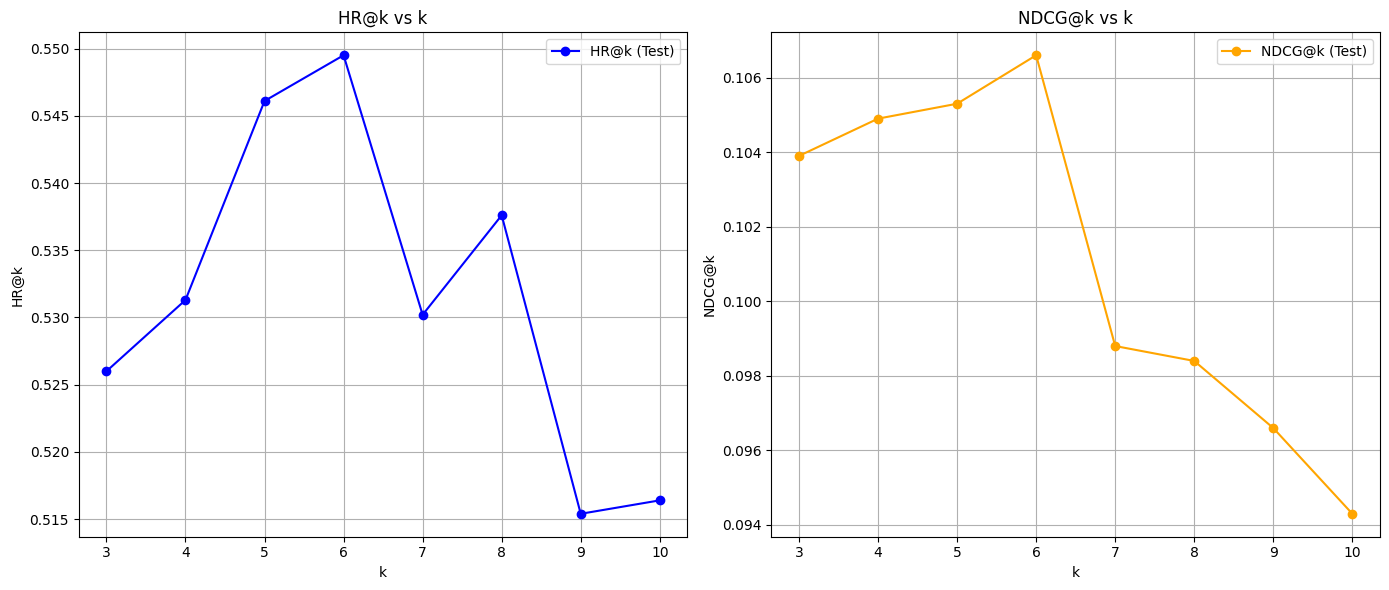

In [54]:
# Re-importing libraries as the code execution environment was reset
import matplotlib.pyplot as plt

# Data from the provided results
k_values = [3, 4, 5, 6, 7, 8, 9, 10]
hit_rates = [0.5260, 0.5313, 0.5461, 0.5495, 0.5302, 0.5376, 0.5154, 0.5164]
ndcg_values = [0.1039, 0.1049, 0.1053, 0.1066, 0.0988, 0.0984, 0.0966, 0.0943]

# Plot HR@k
plt.figure(figsize=(14, 6))

# Plot for HR
plt.subplot(1, 2, 1)
plt.plot(k_values, hit_rates, marker='o', color='blue', label='HR@k (Test)')
plt.title('HR@k vs k')
plt.xlabel('k')
plt.ylabel('HR@k')
plt.xticks(k_values)
plt.legend()
plt.grid(True)

# Plot for NDCG
plt.subplot(1, 2, 2)
plt.plot(k_values, ndcg_values, marker='o', color='orange', label='NDCG@k (Test)')
plt.title('NDCG@k vs k')
plt.xlabel('k')
plt.ylabel('NDCG@k')
plt.xticks(k_values)
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()
